== This week's links ==

* [The lesson video](https://youtu.be/V2h3IOBDvrA)
* [Lesson 4 notes](http://wiki.fast.ai/index.php/Lesson_4_Notes)


In [6]:
%matplotlib inline
import utils
import imp
imp.reload(utils)
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [7]:
path = 'data/ml-latest-small/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size = 64

## Setup data

We're working with the movielens data, which contains one rating per row, like this:

In [8]:
ratings = pd.read_csv(path + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
len(ratings)

100004

Just for displat purposes, let's read in the movie names too.

In [10]:
movie_names = pd.read_csv(path + 'movies.csv').set_index('movieId')['title'].to_dict()

In [11]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [12]:
userid2idx = {o:i for i, o in enumerate(users)}
movieid2idx = {o:i for i, o in enumerate(movies)}

We update the move and use ids so that they are contiguous integers, which we want when using embeddings.

In [13]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [14]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [15]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent facors in each embedding.

In [16]:
n_factors = 50
np.random.seed = 42

Randomly split into training and validation.

In [17]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crostab of the most popular movies and most movie-addicted users which we'll copy into excel for creating a simple example. This is not necessary for any of the modeling below however.

In [13]:
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending = False)[:15]

In [14]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:15]

In [15]:
top_r = ratings.join(topUsers, rsuffix = '_r', how = 'inner', on = 'userId')

In [16]:
top_r = top_r.join(topMovies, rsuffix = '_r', how = 'inner', on = 'movieId')

In [17]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc = np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [18]:
user_in = Input(shape = (1,), dtype = 'int64', name = 'user_in')
u = Embedding(n_users, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(user_in)
movie_in = Input(shape = (1,), dtype = 'int64', name = 'movie_in')
m = Embedding(n_movies, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(movie_in)

In [19]:
x = merge([u, m], mode = 'dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

D:\Users\j00ng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
D:\Users\j00ng\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [20]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 1, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/1
79985/79985 [==============================] - 39s - loss: 9.8195 - val_loss: 4.2756


In [21]:
model.optimizer.lr = 0.01

In [22]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 3, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/3
79985/79985 [==============================] - 12s - loss: 3.1266 - val_loss: 2.8320
Epoch 2/3
79985/79985 [==============================] - 12s - loss: 2.4143 - val_loss: 2.6302
Epoch 3/3
79985/79985 [==============================] - 12s - loss: 2.2485 - val_loss: 2.5807


In [23]:
model.optimizer.lr = 0.001

In [24]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 6, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/6
79985/79985 [==============================] - 11s - loss: 2.1851 - val_loss: 2.5660
Epoch 2/6
79985/79985 [==============================] - 12s - loss: 2.1490 - val_loss: 2.5652
Epoch 3/6
79985/79985 [==============================] - 11s - loss: 2.1228 - val_loss: 2.5619
Epoch 4/6
79985/79985 [==============================] - 11s - loss: 2.0995 - val_loss: 2.5695
Epoch 5/6
79985/79985 [==============================] - 12s - loss: 2.0766 - val_loss: 2.5716
Epoch 6/6
79985/79985 [==============================] - 12s - loss: 2.0571 - val_loss: 2.5816


The [best_benchmarks](http://www.librec.net/example.html) are a bit ober 0.9, so this model doesn't seem to be working that well...

## Bias

The problem is likely yo be taht we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negatibe each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and addin git to our output.

In [18]:
def embedding_input(name, n_in, n_out, reg) :
    inp = Input(shape = (1,), dtype = 'int64', name = name)
    return inp, Embedding(n_in, n_out, input_length = 1, embeddings_regularizer = l2(reg))(inp)

In [19]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [20]:
def create_bias(inp, n_in) :
    x = Embedding(n_in, 1, input_length = 1)(inp)
    return Flatten()(x)

In [21]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [22]:
x = merge([u, m], mode = 'dot')
x = Flatten()(x)
x = merge([x, ub], mode = 'sum')
x = merge([x, mb], mode = 'sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
C:\Users\hjkim\Anaconda3\lib\site-packages\keras-2.0.8-py3.6.egg\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use inst

In [30]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 1, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/1
79985/79985 [==============================] - 14s - loss: 8.8058 - val_loss: 3.5344


In [31]:
model.optimizer.lr = 0.01

In [32]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 6, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/6
79985/79985 [==============================] - 13s - loss: 2.5821 - val_loss: 2.3113
Epoch 2/6
79985/79985 [==============================] - 13s - loss: 1.9987 - val_loss: 2.1140
Epoch 3/6
79985/79985 [==============================] - 13s - loss: 1.8388 - val_loss: 2.0168
Epoch 4/6
79985/79985 [==============================] - 13s - loss: 1.7447 - val_loss: 1.9410
Epoch 5/6
79985/79985 [==============================] - 13s - loss: 1.6649 - val_loss: 1.8763
Epoch 6/6
79985/79985 [==============================] - 13s - loss: 1.5902 - val_loss: 1.8055


In [33]:
model.optimizer.lr = 0.001

In [34]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 10, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/10
79985/79985 [==============================] - 14s - loss: 1.5177 - val_loss: 1.7415
Epoch 2/10
79985/79985 [==============================] - 13s - loss: 1.4466 - val_loss: 1.6876
Epoch 3/10
79985/79985 [==============================] - 14s - loss: 1.3794 - val_loss: 1.6274
Epoch 4/10
79985/79985 [==============================] - 13s - loss: 1.3122 - val_loss: 1.5722
Epoch 5/10
79985/79985 [==============================] - 13s - loss: 1.2490 - val_loss: 1.5229
Epoch 6/10
79985/79985 [==============================] - 13s - loss: 1.1887 - val_loss: 1.4747
Epoch 7/10
79985/79985 [==============================] - 14s - loss: 1.1309 - val_loss: 1.4249
Epoch 8/10
79985/79985 [==============================] - 13s - loss: 1.0766 - val_loss: 1.3839
Epoch 9/10
79985/79985 [==============================] - 13s - loss: 1.0247 - val_loss: 1.3423
Epoch 10/10
79985/79985 [==============================] - 14s - loss: 0.9760 - val_lo

In [35]:
model.optimizer.lr = 0.001

In [36]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 5, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/5
79985/79985 [==============================] - 14s - loss: 0.9291 - val_loss: 1.2698
Epoch 2/5
79985/79985 [==============================] - 13s - loss: 0.8861 - val_loss: 1.2379
Epoch 3/5
79985/79985 [==============================] - 13s - loss: 0.8456 - val_loss: 1.2109
Epoch 4/5
79985/79985 [==============================] - 13s - loss: 0.8076 - val_loss: 1.1812
Epoch 5/5
79985/79985 [==============================] - 14s - loss: 0.7730 - val_loss: 1.1553


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so klooks like a greate approach!

In [37]:
model.save_weights(model_path + 'bias.h5')

In [23]:
model.load_weights(model_path + 'bias.h5')

We can use the model to generate predictions by passing a apir of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [24]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.0111]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [25]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of assocoating one or more inputs with one more more outputs, using the functional API. Here, out input is the movie id (a dingle id), and the output is the movie bias (a single float).

In [26]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that differenr reviewers watch.

In [27]:
sorted(movie_ratings, key = itemgetter(0))[:15]

[(-0.34166905, 'Battlefield Earth (2000)'),
 (-0.21711205, 'Police Academy 6: City Under Siege (1989)'),
 (-0.099890828, 'Super Mario Bros. (1993)'),
 (-0.084710956, 'Jaws 3-D (1983)'),
 (-0.084235586, 'Blade: Trinity (2004)'),
 (-0.062596343, 'House on Haunted Hill (1999)'),
 (-0.028937345, 'Spice World (1997)'),
 (0.021253068, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.02223802, 'Little Nicky (2000)'),
 (0.045479216, 'Wild Wild West (1999)'),
 (0.049571212, 'Road to Wellville, The (1994)'),
 (0.062709987, 'King Kong (1976)'),
 (0.063253045, 'Speed 2: Cruise Control (1997)'),
 (0.091899276, 'Howard the Duck (1986)'),
 (0.10228892, 'Batman & Robin (1997)')]

In [28]:
sorted(movie_ratings, key = itemgetter(0), reverse = True)[:15]

[(1.3739117, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3568963, 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)'),
 (1.3359407, "Amores Perros (Love's a Bitch) (2000)"),
 (1.3331952, 'Rush (2013)'),
 (1.3300768, 'Shawshank Redemption, The (1994)'),
 (1.3277645, 'Band of Brothers (2001)'),
 (1.3138101, 'Man Who Shot Liberty Valance, The (1962)'),
 (1.3079391, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.3001527, 'Cyrano de Bergerac (1990)'),
 (1.3000995, 'Persuasion (1995)'),
 (1.2937472, 'Night of the Living Dead (1968)'),
 (1.2726806, 'Letters from Iwo Jima (2006)'),
 (1.2700678, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2698252, 'Argo (2012)'),
 (1.2603014, 'All That Jazz (1979)')]

We can now so the same thing for the embeddings.

In [29]:
get_movie_emb = Model(movie_in, m)

In [30]:
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use PCA to simplify them down to just 3 vectors.

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [32]:
fac0 = movie_pca[0]

In [33]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critical acclaimed' or 'classic'.

In [34]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.053901561279247424, 'Usual Suspects, The (1995)'),
 (0.051678638143491058,
  "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.050942796569092279, 'American Beauty (1999)'),
 (0.05092362386076732, 'Shawshank Redemption, The (1994)'),
 (0.050579263907363531,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.049647235174514782, 'Godfather, The (1972)'),
 (0.049254378340081076, 'Clerks (1994)'),
 (0.049200803135804147, 'Silence of the Lambs, The (1991)'),
 (0.049168427377632523, 'Toy Story (1995)'),
 (0.048474549632846989,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)')]

In [35]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.014419465381166471, 'Anaconda (1997)'),
 (-0.010188408924994676, 'Police Academy 3: Back in Training (1986)'),
 (-0.0097465145757967553, 'Police Academy 6: City Under Siege (1989)'),
 (-0.0093089186064237873, 'Bio-Dome (1996)'),
 (-0.0092445720403632279, 'Blade: Trinity (2004)'),
 (-0.0087202497122176904, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0076378829461261743, 'RoboCop 3 (1993)'),
 (-0.0074043875437411026, 'Battlefield Earth (2000)'),
 (-0.0073918565823843539, 'Inspector Gadget (1999)'),
 (-0.0073641163447687886, 'Bachelor, The (1999)')]

In [36]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [37]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.10316790518395727, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.10142666230777057, 'Armageddon (1998)'),
 (0.07361771156413055, 'Pearl Harbor (2001)'),
 (0.069747615503237367, 'Outbreak (1995)'),
 (0.06968540266742293, 'Jurassic Park (1993)'),
 (0.068312347338795668, 'Stargate (1994)'),
 (0.068151002291017421, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.067722256083463467, 'Titanic (1997)'),
 (0.064508467079230983, 'Speed (1994)'),
 (0.063930856939192288, 'Net, The (1995)')]

In [38]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.067885417460224085, 'Annie Hall (1977)'),
 (-0.060190889723688648, 'City Lights (1931)'),
 (-0.05945833089948082, 'Apocalypse Now (1979)'),
 (-0.056094011403448218, '8 1/2 (8½) (1963)'),
 (-0.055145506473705093, '2001: A Space Odyssey (1968)'),
 (-0.054629249386263498, 'Big Lebowski, The (1998)'),
 (-0.05353465065583133, 'Brokeback Mountain (2005)'),
 (-0.052970621248675305, 'Dog Day Afternoon (1975)'),
 (-0.052165572631984819, 'Room with a View, A (1986)'),
 (-0.051274105832314155, 'Bringing Up Baby (1938)')]

In [39]:
fac2 = movie_pca[2]

In [40]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [41]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.095549714326663315, 'Matrix, The (1999)'),
 (0.094948128618646682,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.093316305947314812, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.089266233519453245, 'Seven (a.k.a. Se7en) (1995)'),
 (0.080596196115618926, 'Silence of the Lambs, The (1991)'),
 (0.080189292289828101, '2001: A Space Odyssey (1968)'),
 (0.077402548433805868, 'Terminator 2: Judgment Day (1991)'),
 (0.075887834651764755,
  'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.075158944970907068, 'Pulp Fiction (1994)'),
 (0.068373502277923798, 'Aliens (1986)')]

In [42]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.077270429480120292, 'Sabrina (1995)'),
 (-0.075383268652958732, 'Legally Blonde (2001)'),
 (-0.070015327913502484, 'Sleepless in Seattle (1993)'),
 (-0.064800496300335977, 'Chicago (2002)'),
 (-0.06259897970625225, 'Boot, Das (Boat, The) (1981)'),
 (-0.062221953809236438, 'Room with a View, A (1986)'),
 (-0.058726681010827168,
  'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (-0.058319479907332994, 'Sleeping Beauty (1959)'),
 (-0.057236227205614554, 'Bend It Like Beckham (2002)'),
 (-0.056809192838059026, 'While You Were Sleeping (1995)')]

We can draw a picture to see how varioous movies appear on th emap of these components. This picture shows the 1st and 3rd components.

In [49]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save noebook stdout and stderr
imp.reload(sys)
#sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

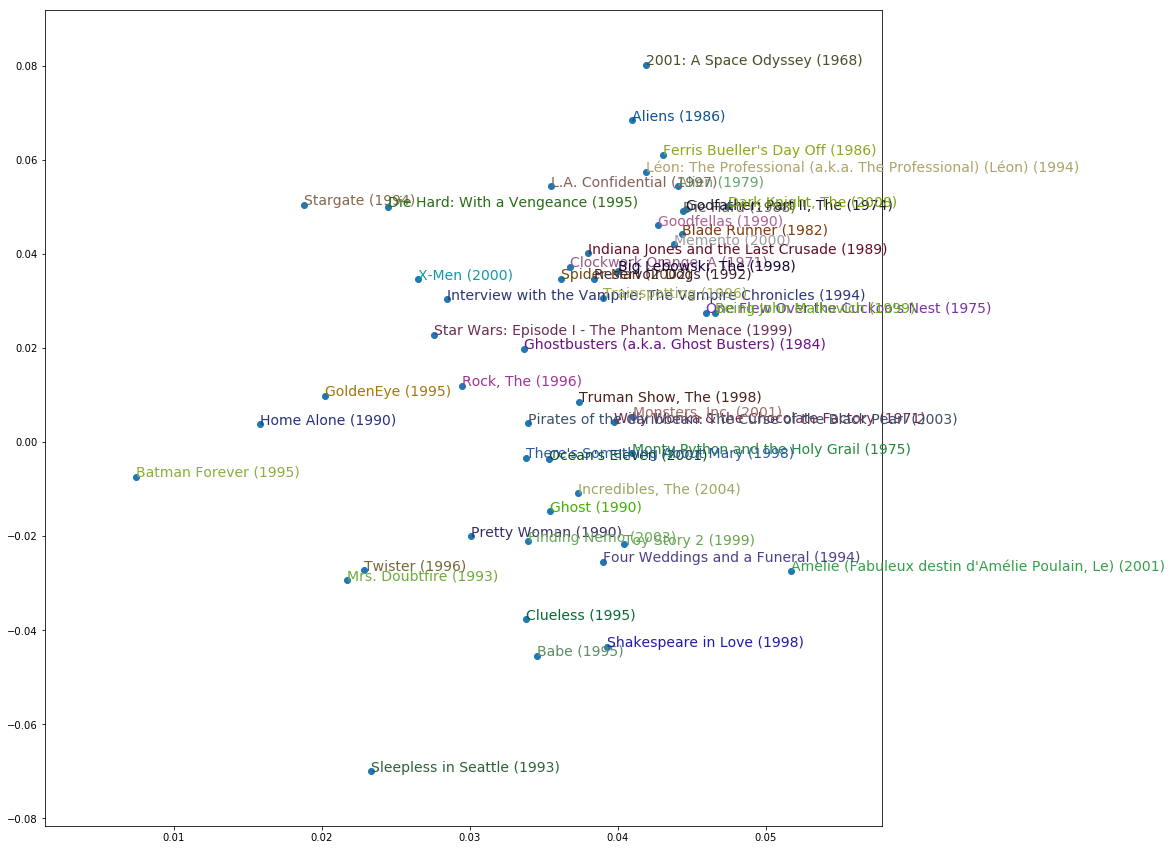

In [51]:
start = 50; end = 100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize = (15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y) :
    plt.text(x, y, movie_names[movies[i]], color = np.random.rand(3) * 0.7, fontsize = 14)
plt.show()

## NN

Rather than creating a special purpose architecture (like out dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concateneate the user and movie embeddings into a single vector, which we feed into the neural net.

In [53]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [55]:
x = merge([u, m], mode = 'concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation = 'relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss = 'mse')

C:\Users\hjkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
C:\Users\hjkim\Anaconda3\lib\site-packages\keras-2.0.8-py3.6.egg\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [57]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size = batch_size, epochs = 8, validation_data = ([val.userId, val.movieId], val.rating))

Train on 79816 samples, validate on 20188 samples
Epoch 1/8
79816/79816 [==============================] - 34s - loss: 2.3672 - val_loss: 0.8887
Epoch 2/8
79816/79816 [==============================] - 33s - loss: 1.4378 - val_loss: 0.8876
Epoch 3/8
79816/79816 [==============================] - 33s - loss: 1.2140 - val_loss: 0.8633
Epoch 4/8
79816/79816 [==============================] - 34s - loss: 1.0379 - val_loss: 0.8529
Epoch 5/8
79816/79816 [==============================] - 34s - loss: 0.9157 - val_loss: 0.8425
Epoch 6/8
79816/79816 [==============================] - 33s - loss: 0.8504 - val_loss: 0.8324
Epoch 7/8
79816/79816 [==============================] - 33s - loss: 0.8242 - val_loss: 0.8308
Epoch 8/8
79816/79816 [==============================] - 33s - loss: 0.8135 - val_loss: 0.8329


This improves on out already impressive even further!